In [ ]:
import sys; sys.path.append('..')
from builtins import print

from about_time import about_time  # ❯ pip install about-time

In [ ]:
from brain.sdk import BrainClient

# set OPENAI_API_KEY environment variable
# brain start --debug

brain = BrainClient("http://127.0.0.1:8000")

# Basic Usage

**Reasoner** 
- Systems that analyze input and provide meaningful output.
- Use the `@reasoner` decorator on a Python function that returns a system prompt and user prompt.
- Responses are formatted according to the attached schema.

In [ ]:
from pydantic import BaseModel, Field


class AnswerSchema(BaseModel):
    answer:str
    explanation:str


# Attach tags or pass optional name to the reasoner
@brain.reasoner(name="Sample Reasoner",schema=AnswerSchema,tags=["sample","quick-start"])
def sample_reasoner(system_prompt, user_prompt):
    return dict(system_prompt=system_prompt, user_prompt=user_prompt)

brain.list_reasoners()

                                Reasoners in Project: Default Project                                 
                                                                                                      
  Reasoner          ID                                     Tags                      Created At       
 ──────────────────────────────────────────────────────────────────────────────────────────────────── 
  Sample Reasoner   1305c165-2c79-463f-943b-37d92acbdd30   sample, quick-start   2024-12-03 03:52:21

We run the reasoner via their ID, this is so that we can swap out the implementation of the reasoner without changing the code that uses it in real-time.

In [ ]:
question = "How many R's are there in the word 'STRAWBERRY'?"

with about_time() as t_sync:
    answer_sync = brain.use(sample_reasoner.id)(
        system_prompt="You are an expert letter counter, answer this question",
        user_prompt=question,
    )
    
with about_time() as t_async:
    fut=[]
    for _ in range(5):
        fut.append(brain.use(sample_reasoner.id,run_async=True)(
            system_prompt="You are an expert letter counter, answer this question",
            user_prompt=question,
        ))
    answer_async = [f.result() for f in fut]
    

print("\033[4m1 synchronous call\033[0m")
print(f"Time Taken: {t_sync.duration_human}")
print(f"Answer: {answer_sync}")
print("\n" + "-" * 50 + "\n")
print("\033[4m5 asynchronous calls\033[0m")
print(f"Total Time Taken for 5 async calls: {t_async.duration_human}")
for idx, ans in enumerate(answer_async, start=1):
    print(f"{idx}. Answer: {ans}")

1 synchronous call
Time Taken: 460.8ms
Answer: answer='2' explanation="The word 'STRAWBERRY' contains two occurrences of the letter 'R'."

--------------------------------------------------

5 asynchronous calls
Total Time Taken for 5 async calls: 567.5ms
1. Answer: answer='2' explanation="The word 'STRAWBERRY' contains two occurrences of the letter 'R'."
2. Answer: answer='2' explanation="The word 'STRAWBERRY' contains the letter 'R' twice."
3. Answer: answer='2' explanation="The word 'STRAWBERRY' contains two instances of the letter 'R'."
4. Answer: answer='2' explanation="The word 'STRAWBERRY' contains the letter 'R' twice, specifically in the second half of the word."
5. Answer: answer='2' explanation="The word 'STRAWBERRY' contains two occurrences of the letter 'R'."


## Multiagents

- Encapsulate multiple reasoners.
- Combine outputs of multiple reasoners into a single workflow.
- Do not have a schema.
- Decorated with the `@multi_agent` decorator.
- Define complex units of work requiring multiple specialized reasoners.

### The story writer

In [ ]:
from typing import List

from pydantic import BaseModel, Field


# Define schemas for reasoners
class Story(BaseModel):
    story_next_lines: str = Field(..., description="Continuation of the story. Do not repeat the story in the prompt, just provide the continuation.")

class Character(BaseModel):
    name: str = Field(..., description="The name of the character.")
    description: str = Field(..., description="The detailed description of the character and their role in the story.")

class Action(BaseModel):
    type: str = Field(..., description=f"The type of action to take. One of given actions.")
    action_description: str = Field(..., description="suggested continuation or action for the story.")

# Define reasoners
@brain.reasoner(schema=Story)
def story_extender(story: str, action: str):
    """Extends the story based on the provided action."""
    system_prompt = "You are a skilled storyteller."
    user_prompt = (
        f"The current story is:\n{story}\n"
        f"Based on the action '{action}', give a short (~1-3 lines) continuation to the story. If the action is 'end_story', conclude the story gracefully."
    )
    return user_prompt, system_prompt

@brain.reasoner(schema=Character)
def character_describer(name: str, story: str):
    """Introduces a character based on the current story context."""
    system_prompt = "You are a creative writer."
    user_prompt = (
        f"The current story is:\n{story}\n"
        f"Introduce the character named {name} into the story. Use their personality and traits to make their role meaningful."
    )
    return user_prompt, system_prompt

@brain.reasoner(schema=Action)
def action_extender(story: str, actions: List[str]):
    """Suggests the next action for the story."""
    system_prompt = "You are a narrative strategist."
    user_prompt = (
        f"The current story is:\n{story}\n"
        f"Suggest the next action for the story.Based on existing story, choose one of the following that would be the best next step"
        f"\nActions:{actions+['introduce character']}."
        "Clearly state the action type and provide the next_action description."
    )
    return user_prompt, system_prompt

Let's define the multiagent that will use all these reasoners above to generate an interesting story

In [ ]:
from random import choice
from typing import List


@brain.multi_agent(name="Story Builder", tags=["storytelling","quick-start"])
def story_builder(start: str, characters: List[str],actions=List[str], n: int = 5):
    """
    Builds a story iteratively by introducing characters and progressing actions.

    Args:
        start (str): The starting line of the story.
        characters (List[str]): List of character names to introduce dynamically.
        n (int): Maximum number of iterations to build the story.

    Returns:
        dict: The final story, introduced characters, remaining characters, and final action.
    """
    story = start
    introduced_characters = []  # Track introduced characters
    remaining_characters = characters[:]  # Characters not yet introduced
    actions_proposed=[]
    
    for _ in range(n-1):
        # Step 1: Determine the next action
        action = brain.use(action_extender.id)(story=story,actions=actions)
        actions_proposed.append(action)
        
        if action.type == "introduce character" and remaining_characters:
            # Introduce a random character
            character_name = choice(remaining_characters)
            
            remaining_characters.remove(character_name)
            character_description = brain.use(character_describer.id)(name=character_name, story=story).description
            story += brain.use(story_extender.id)(story=story, action=f"Introduce {character_name}: {character_description}").story_next_lines
            introduced_characters.append(character_name)

        else:
            story += brain.use(story_extender.id)(story=story, action=f"Type:{action.type} Descprition{action.action_description}").story_next_lines
            

    # Conclude the story
    story += brain.use(story_extender.id)(story=story, action="end_story").story_next_lines

    # Return the final result
    return {
        "final_story": story,
        "introduced_characters": introduced_characters,
        "remaining_characters": remaining_characters,
        "final_action": actions_proposed,
    }

In [ ]:
from rich import print

start="Once upon a time, in a faraway land "
characters=["Alice", "Bob", "Charlie", "David", "Eve"]
action=['add happy emotion', 'add sad emotion', 'add twist','make it magical','add fight']
n=6

story=story_builder(start, characters,actions=action, n=n)

print(story)

{
    'final_story': 'Once upon a time, in a faraway land One day, while exploring the depths of a misty forest, 
David stumbled upon an ancient map carved onto a stone tablet, detailing a hidden treasure that could save his 
village from impending doom. Determined to follow its cryptic clues, he rallied his fellow villagers, igniting a 
spark of hope in their hearts.Together, David and Charlie set off deeper into the forest, the ancient map clutched 
tightly in David’s hands. With each riddle they faced, Charlie’s infectious laughter echoed through the trees, 
reminding everyone that no challenge was too great with friendship and courage at their side.Emboldened by the 
magic that surrounded them, David and Charlie stepped forward, following the dancing branches. The spirits’ 
whispers grew clearer, leading them to a magnificent clearing where the treasure lay hidden beneath a blossom of 
shimmering flowers, radiating a light brighter than the sun.As the guardian spirit bestowed her magic upon them, 
the flowers pulsed with vibrant energy, casting a protective shield over the village. United by their newfound 
strength, David and Charlie led the villagers back home, their hearts filled with hope, knowing that together they 
could overcome any darkness that threatened their land.As the villagers danced beneath the rain of golden feathers,
laughter mingled with the melody of the spirits. David and Charlie stood at the center, their bond stronger than 
ever, knowing that this moment marked the dawn of a new era filled with wonder and magic for their beloved 
village.As the sun dipped below the horizon, painting the sky with hues of orange and pink, David and Charlie 
exchanged a knowing smile, their adventure forever engraved in the hearts of their villagers. They understood that 
the true treasure was not gold or jewels, but the spirit of unity and courage they had forged together. From that 
day on, the village thrived, and the tales of their journey spread far and wide, inspiring others to seek their own
adventures filled with friendship and hope.',
    'introduced_characters': ['David', 'Charlie'],
    'remaining_characters': ['Alice', 'Bob', 'Eve'],
    'final_action': [
        Action(
            type='introduce character',
            action_description='Introduce a mysterious traveler who arrives in the village, bringing tales of 
adventure and magic from distant lands.'
        ),
        Action(
            type='introduce character',
            action_description="As David prepares to embark on the treasure hunt, a mysterious old woman appears at
the edge of the forest, claiming to be a guardian of the map. She offers to guide them in exchange for a promise to
uphold the forest's ancient magic."
        ),
        Action(
            type='make it magical',
            action_description='As they decode the next riddle, the forest around them begins to shimmer with 
golden light. Suddenly, the trees grow animated, their branches dancing gracefully, revealing hidden pathways that 
lead deeper into the enchanted woods, while the whispers of ancient spirits guide them with gentle encouragement.'
        ),
        Action(
            type='make it magical',
            action_description='As David and Charlie kneel before the blossoms, the flowers suddenly bloom wide 
open, revealing not just gold and jewels but also a guardian spirit of the forest. Her ethereal presence fills the 
air with a warm glow as she speaks in a melodious voice, explaining that the true treasure is not the riches, but 
the power of unity and courage that they showed while searching for it. Enchanted by her words, the villagers feel 
a surge of energy, as the spirit gifts them with protective magic to ward off the impending doom.'
        ),
        Action(
            type='make it magical',
            action_description='As they returned to the village, the protective shield began to shimmer and pulse 
in time with their heartbeats. Suddenly

In [ ]:
runs=brain.list_runs(return_data=True)

                                   MultiAgent Session Runs in Project: Default Project                                    
                                                                                                                          
  Session ID                              MultiAgent     Reasoner Calls          Start Date & Time    Total Duration (s)  
 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  c6e68a09-764d-4598-9adf-2cf4900431fb   Story Builder   action_extender        2024-12-03 03:52:22         15.35         
                                                         (0.79s) →                                                        
                                                         character_describer                                              
                                                         (1.45s) →                                                        
                                                         story_extender                                                   
                                                         (0.89s) →                                                        
                                                         action_extender                                                  
                                                         (1.63s) →                                                        
                                                         character_describer                                              
                                                         (1.63s) →                                                        
                                                         story_extender                                                   
                                                         (1.24s) →                                                        
                                                         action_extender                                                  
                                                         (1.21s) →                                                        
                                                         story_extender                                                   
                                                         (1.03s) →                                                        
                                                         action_extender                                                  
                                                         (1.31s) →                                                        
                                                         story_extender                                                   
                                                         (0.92s) →                                                        
                                                         action_extender                                                  
                                                         (1.12s) →                                                        
                                                         story_extender                                                   
                                                         (0.82s) →                                                        
                                                         story_extender                                                   
                                                         (1.29s)

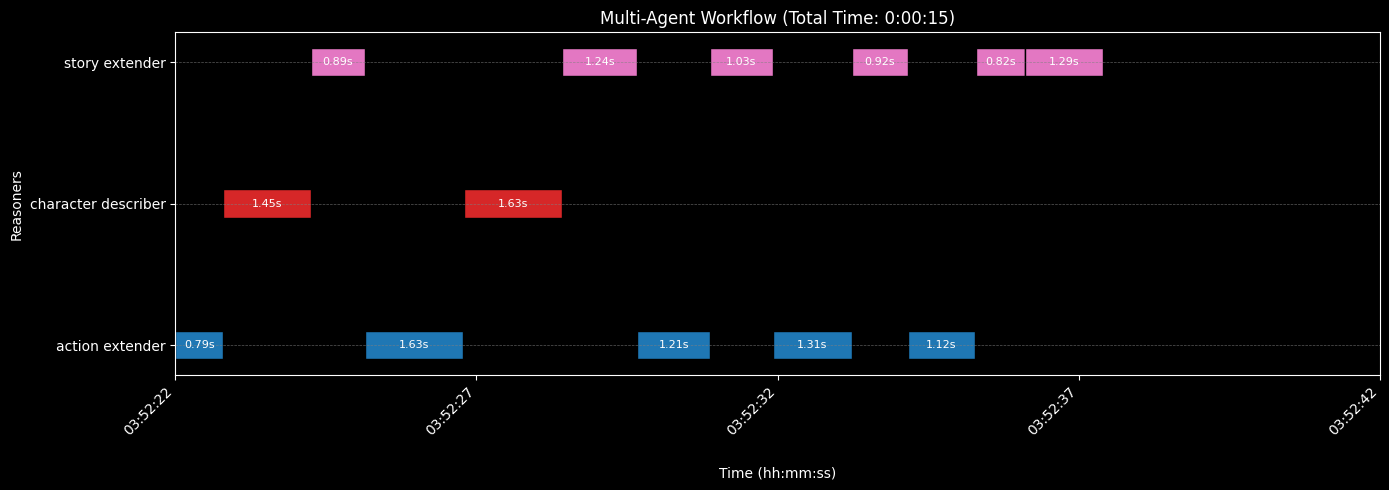

In [ ]:
from brain.visualize import plot_workflow_matplotlib

lineage=brain.get_call_graph(runs[0]['session_id'])
fig=plot_workflow_matplotlib(lineage['lineage'])

## Modifiers

- Modifiers are objects that can be passed to modify the runtime behavior of the reasoner.
- Passed as keyword arguments when using the reasoner.
- Custom modifiers can be defined by inheriting from the `ModifierBase` class.
- Built-in modifiers include reasoning enhancers like CoT/IoT, guardrails, transformations, etc.

In [ ]:
from brain.modifiers import COT as ChainOfThought

question = "How many R's are there in the word 'STRAWBERRY'?"
    
fut=[]
for _ in range(5):
    fut.append(brain.use(sample_reasoner.id,run_async=True)(
        system_prompt="You are an expert letter counter, answer this question",
        user_prompt=question,
    ))
answer_wo_mod = [f.result().answer for f in fut]
    
fut=[]
for _ in range(5):
    fut.append(brain.use(sample_reasoner.id,run_async=True,modifier=ChainOfThought())(
        system_prompt="You are an expert letter counter, answer this question",
        user_prompt=question,
    ))
answer_w_mod = [f.result().answer for f in fut]

print(f"Question: {question}\n\n"
f"Answers without modifier : {answer_wo_mod}\n"
f"Answers with CoT modifier: {answer_w_mod}")

Question: How many R's are there in the word 'STRAWBERRY'?

Answers without modifier : ['2', '2', '2', '2', '2']
Answers with CoT modifier: ['3', '3', '2', '3', '3']

In [ ]:
from random import choice
from typing import List


@brain.multi_agent(name="Story Builder with COT", tags=["storytelling", "quick-start"])
def story_builder_mod(start: str, characters: List[str], actions=List[str], n: int = 5):
    """
    Builds a story iteratively by introducing characters and progressing actions.

    Args:
        start (str): The starting line of the story.
        characters (List[str]): List of character names to introduce dynamically.
        n (int): Maximum number of iterations to build the story.

    Returns:
        dict: The final story, introduced characters, remaining characters, and final action.
    """
    story = start
    introduced_characters = []  # Track introduced characters
    remaining_characters = characters[:]  # Characters not yet introduced
    actions_proposed = []

    for _ in range(n - 1):
        # Step 1: Determine the next action
        # Use Chain of Thought modifier to decide the next action
        action = brain.use(action_extender.id,modifier=ChainOfThought(num_steps=2))(story=story, actions=actions)
        actions_proposed.append(action)

        if action.type == "introduce character" and remaining_characters:
            # Introduce a random character
            character_name = choice(remaining_characters)

            remaining_characters.remove(character_name)
            character_description = brain.use(character_describer.id)(
                name=character_name, story=story
            ).description
            
            # Use Chain of Thought modifier to extend the story
            story += brain.use(story_extender.id, modifier=ChainOfThought(num_steps=2))(
                story=story,
                action=f"Introduce {character_name}: {character_description}",
            ).story_next_lines
            introduced_characters.append(character_name)

        else:
            story += brain.use(story_extender.id)(
                story=story,
                action=f"Type:{action.type} Descprition{action.action_description}",
            ).story_next_lines

    # Conclude the story
    story += brain.use(story_extender.id)(
        story=story, action="end_story"
    ).story_next_lines

    # Return the final result
    return {
        "final_story": story,
        "introduced_characters": introduced_characters,
        "remaining_characters": remaining_characters,
        "final_action": actions_proposed,
    }


print(story_builder_mod(start, characters, actions=action, n=n)["final_story"])

Once upon a time, in a faraway land Emboldened by the warmth of the villagers' smiles, Bob decided it was time to 
embark on an adventure with them, promising that together they would face whatever challenges lay ahead.The energy 
was infectious, and soon Bob found himself swept up in the merriment, twirling with children and singing along with
the elders as they prepared for the journey. With hearts united and spirits high, they set off, leaving behind the 
familiar village and stepping into the embrace of a new adventure.As they ventured deeper into the forest, the air 
began to shimmer with golden light, and the trees swayed gently, their whispers guiding the villagers towards a 
hidden path that glowed with ethereal magic. With each step, Bob felt a surge of wonder, sensing that the forest 
was alive and welcoming them into its enchanted embrace.As the villagers marveled at the fairies' twirls, the air 
filled with laughter and joy, transforming their adventure into a vibrant celebration. The fairies, sensing their 
delight, showered them with sparkling dust, creating an aura of shimmering light around the group. With newfound 
energy and hope, they continued down the path, ready to embrace whatever wonders awaited them in the heart of the 
enchanted forest.As they stepped into the glade, the villagers gasped in awe at the sight of the luminous flowers 
swaying rhythmically, their gentle melodies harmonizing with the whispers of the wind. With each note, the flowers 
seemed to invite them closer, revealing secrets of the forest's magic and encouraging Bob and his friends to dance 
among them, their laughter intertwining with the enchanting song.As the sun began to set, casting a warm glow over 
the glade, Bob and the villagers realized they had discovered not only the wonders of the forest but also the magic
of their own hearts united in joy. With promises to return, they made their way back home, forever changed by the 
adventure that had bonded them together in friendship and wonder.

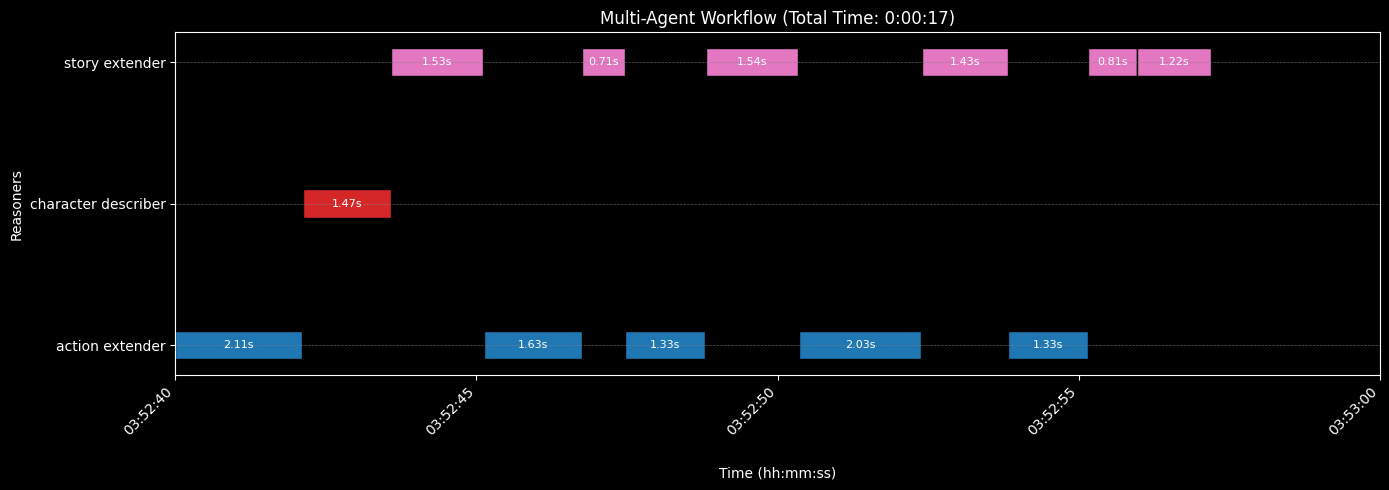

In [ ]:
runs=brain.list_runs(print_table=False,return_data=True)
lineage=brain.get_call_graph(runs[0]['session_id'])
fig=plot_workflow_matplotlib(lineage['lineage'])

In [ ]:
brain.list_reasoners()
brain.list_multiagents()

                                  Reasoners in Project: Default Project                                   
                                                                                                          
  Reasoner              ID                                     Tags                      Created At       
 ──────────────────────────────────────────────────────────────────────────────────────────────────────── 
  action_extender       0fe5980c-3a42-468f-96b9-29b73ba72c6a                         2024-12-03 03:52:22  
                                                                                                          
  character_describer   710e98ac-2971-4b5d-8bba-e3acf0ca1386                         2024-12-03 03:52:22  
                                                                                                          
  story_extender        ea6b3b7f-0e4b-49c4-9178-fefd97502bfd                         2024-12-03 03:52:22  
                                                                                                          
  Sample Reasoner       1305c165-2c79-463f-943b-37d92acbdd30   sample, quick-start   2024-12-03 03:52:21

                                   MultiAgents in Project: Default Project                                    
                                                                                                              
  MultiAgent               ID                                     Tags                       Created At       
 ──────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  Story Builder with COT   c5aa6347-e735-4637-8553-61746fb90bd4   storytelling,          2024-12-03 03:52:40  
                                                                  quick-start                                 
                                                                                                              
  Story Builder            b0c9f361-472d-46bc-a95a-813c4a09126f   storytelling,          2024-12-03 03:52:22  
                                                                  quick-start